In [2]:
import pennylane as qml
from pennylane import numpy as np

from tqdm import tqdm
from IPython.display import clear_output

import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import cv2
from functools import reduce
import random
import math
import matplotlib.pyplot as plt

## spiral 분포

In [3]:
data_num = 2000
theta = np.linspace(0, 5*np.pi, data_num)  # 각도 범위를 정의합니다.
radius = np.linspace(0, 0.9, data_num)  # 반지름 범위를 정의합니다.
xx = radius * np.cos(theta) + 0.012 * np.random.randn(data_num)  # x 좌표 계산
yy = radius * np.sin(theta) + 0.012 * np.random.randn(data_num)  # y 좌표 계산

x = np.column_stack((xx, yy))  # x와 y 좌표를 합쳐서 데이터 생성
print("x shape = ", x.shape)

x shape =  (2000, 2)


## box 분포

In [32]:
data_num = 2000
xx = np.random.uniform(0.4, 0.8, data_num) + 0.012 * np.random.randn(data_num)  # x 좌표 계산
yy = np.random.uniform(0.2, 0.7, data_num) + 0.012 * np.random.randn(data_num)  # y 좌표 계산

x = np.column_stack((xx, yy))  # x와 y 좌표를 합쳐서 데이터 생성
print("x shape = ", x.shape)

x shape =  (2000, 2)


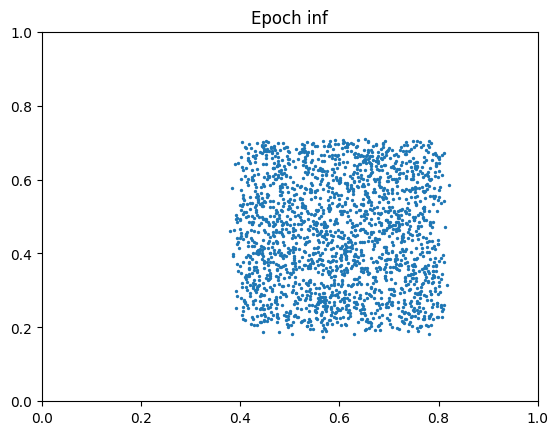

In [33]:
np.random.shuffle(x)
plt.scatter(x[:,0], x[:,1], s=2.0)
plt.title('Epoch inf')
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

In [34]:
# setting torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [35]:
noise_qubits = 4
output_qubits = 2
assert(output_qubits <= noise_qubits-1) # 출력 큐빗은 noise qubit미만이어야 한다.
code_qubits = 1
n_qubits = noise_qubits + code_qubits

n_layers = 7
BATCH_SIZE = 16
print("n_qubits = {} n_layers = {}".format(n_qubits, n_layers))

dev = qml.device("default.qubit", wires=n_qubits)
# dev = qml.device("ionq.simulator", wires=2)
# dev = qml.device("ionq.qpu", wires=2)

n_qubits = 5 n_layers = 7


In [73]:
def generator_init(generator_input):
    for i in range(n_qubits):
        qml.RY(generator_input[i]*np.pi/2, wires=i) # TODO: *a 해서 값 범위 맞추기

def generator_layer(params):
    for i in range(n_qubits):
        qml.RX(params[i][0], wires=i)
        qml.RY(params[i][1], wires=i)
        qml.RZ(params[i][2], wires=i)
    
    for i in range(n_qubits):
        qml.CNOT(wires=[i, (i+1)%n_qubits])

@qml.qnode(dev, interface="torch")
def generator_circuit(params, generator_input):
    """
    quantum circuit nodeq1
    generator_input (np.array(큐빗)) : 생성기 입력 seed (noise + code)
    params (torch.Tensor(레이어,큐빗,3)): a parameter
    마지막 측정은 모두 Z로
    """

    generator_init(generator_input)

    for param in params:
        generator_layer(param)

    return [qml.probs(wires=i) for i in range(n_qubits)]

def generator_forward(params, generator_input):
    # 제너레이터 돌리고 결과 return하는 함수
    generator_output = [generator_circuit(params, single_in)[::2] for single_in in generator_input]
    generator_output = torch.stack(generator_output) # (BATCH_SIZE, n_qubits) 차원
    generator_output = 2 / np.pi * torch.arcsin(torch.sqrt(generator_output)) # (BATCH_SIZE, n_qubits) 차원

    return generator_output[:, :output_qubits], generator_output[:, -code_qubits:] # noise, code 순서로 반환


def generator_cost_fn(params, mine = False, qmine = False):

    generator_input = torch.rand((BATCH_SIZE, n_qubits)) * 2 - 1 # -1~1 사이의 랜덤한 값으로 초기화
    code_input = generator_input[:, -code_qubits:] # 입력중에서 code만 뽑는다. (BATCH_SIZE, code_qubits)

    generator_output, code_output = generator_forward(params, generator_input) # 출력을 뽑아낸다

    generator_output = generator_output.to(torch.float32)
    # print("code out shape = ", code_output.shape)
    
    disc_output = discriminator(generator_output) # 밑에 코드에서 정의됨
    gan_loss = torch.log(1-disc_output).mean()
    # print("gan_loss = ", gan_loss, gan_loss.shape)
    
    t = (code_input - code_output).pow(2).mean()
    return gan_loss+t*0, gan_loss, t # TODO: 이건 분석용으로 넣어놓음.지워야 함.

    gan_loss += t # code loss 추가

    if mine:
        gan_loss += 0 # TODO: mine loss 추가하기
    elif qmine:
        gan_loss += 0 # TODO: qmine loss 추가하기

    return gan_loss


def prediction(params, image, debug=False):
    prob_0 = 0
    prob_1 = 0
    for i in range(n_layers):
        prob_0 += circuit(params[:i+1], (image, 0))
        prob_1 += circuit(params[:i+1], (image, 1))

    if (debug):
        return (int(prob_0 <= prob_1), prob_0, prob_1)
    return int(prob_0 <= prob_1)

In [74]:
a = generator_circuit(generator_params, [1,2,3,4,5])

In [75]:
import torch.nn as nn
from torch.nn import functional as F

class LinearDiscriminator(nn.Module):
    def __init__(self, input_dim=output_qubits):
        super().__init__()
        self.hidden_size = 100
        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, 1),
            nn.Sigmoid())

        self.input_dim = input_dim

    def forward(self, x):
        if(len(x.shape) != 2):
            x = x.view(x.shape[0], -1)

        return self.layers(x)

disc_loss_fn = nn.BCELoss()

def disc_cost_fn(real_input, fake_input, smoothing=False):
    batch_num = real_input.shape[0]

    disc_real = discriminator(real_input)
    disc_fake = discriminator(fake_input)

    real_label = torch.ones((batch_num, 1)).to(device)
    fake_label = torch.zeros((batch_num, 1)).to(device)
    
    if smoothing:
        real_label = real_label - 0.3*torch.rand(real_label.shape).to(device)
    
    loss = 0.5 * (disc_loss_fn(disc_real, real_label) + disc_loss_fn(disc_fake, fake_label))
    
    return loss


In [76]:
generator_params = Variable(torch.tensor(np.random.normal(-np.pi, np.pi, (n_layers, n_qubits, 3))), requires_grad=True)
print("parameter shape: ", generator_params.shape)

discriminator = LinearDiscriminator()

parameter shape:  torch.Size([7, 5, 3])


In [77]:
G_opt = torch.optim.Adam([generator_params], lr=1e-3)
D_opt = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

100%|██████████| 62/62 [00:58<00:00,  1.07it/s, G_loss=-.692, D_loss=0.691]

epoch: 1, D_loss: 0.6913771456287753, G_loss: -0.6920271054390938
a_loss: -42.905680537223816, b_loss: 32.66246096758158
좌표값 평균 =  0.5605464 0.48807392


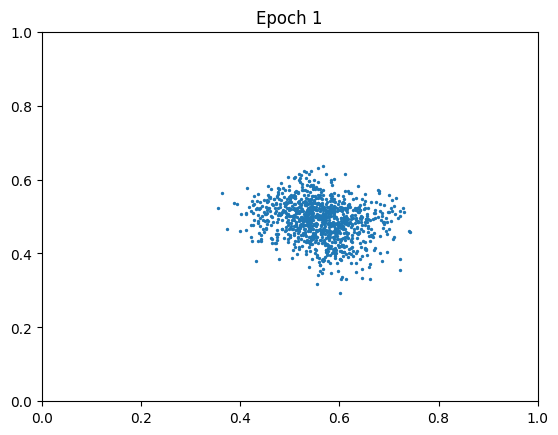

100%|██████████| 62/62 [00:59<00:00,  1.05it/s, G_loss=-.691, D_loss=0.691]

epoch: 2, D_loss: 0.6906667784337075, G_loss: -0.6909764659020209
a_loss: -42.84054088592529, b_loss: 33.83639545435123
좌표값 평균 =  0.60072964 0.46336997


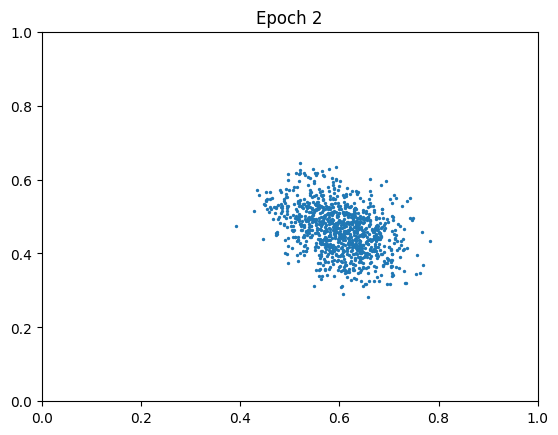

100%|██████████| 62/62 [01:01<00:00,  1.02it/s, G_loss=-.688, D_loss=0.69] 

epoch: 3, D_loss: 0.6901720195047317, G_loss: -0.6884971501365784
a_loss: -42.686823308467865, b_loss: 33.954616655382445
좌표값 평균 =  0.61308086 0.43161306


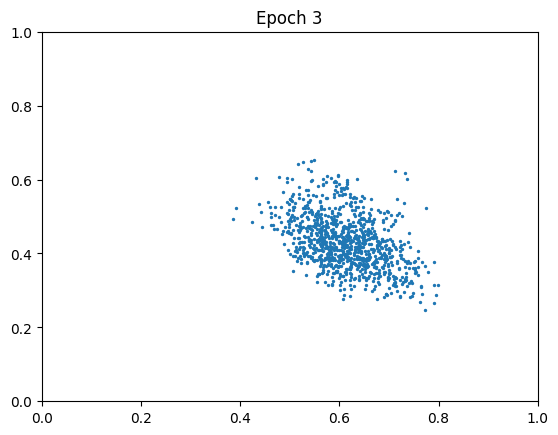

100%|██████████| 62/62 [00:58<00:00,  1.05it/s, G_loss=-.685, D_loss=0.687]

epoch: 4, D_loss: 0.6867017572925936, G_loss: -0.6845250418109279
a_loss: -42.44055259227753, b_loss: 35.06937004090643
좌표값 평균 =  0.6152079 0.42903855


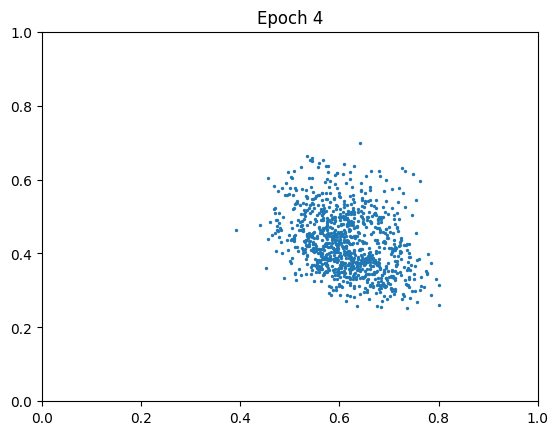

100%|██████████| 62/62 [00:58<00:00,  1.06it/s, G_loss=-.687, D_loss=0.686]

epoch: 5, D_loss: 0.6855569510690628, G_loss: -0.6872675486149327
a_loss: -42.610588014125824, b_loss: 35.65798279294648
좌표값 평균 =  0.5889445 0.49222916


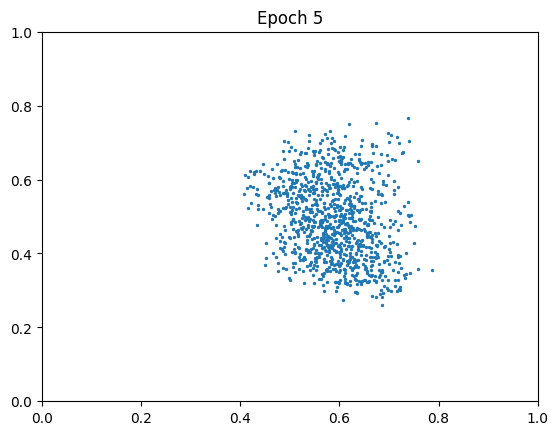

100%|██████████| 62/62 [01:01<00:00,  1.01it/s, G_loss=-.681, D_loss=0.682]

epoch: 6, D_loss: 0.6815700338732812, G_loss: -0.6813514299931065
a_loss: -42.2437886595726, b_loss: 34.311064257843924
좌표값 평균 =  0.5902107 0.45845068


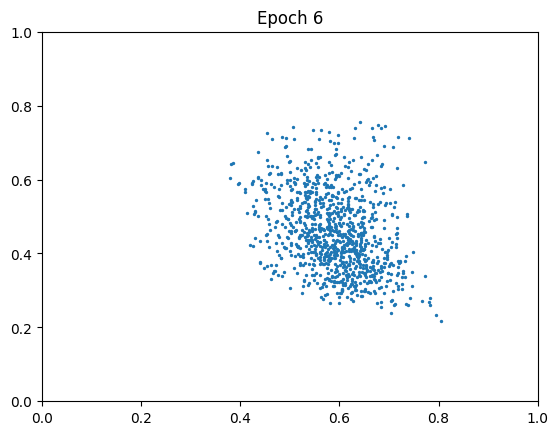

100%|██████████| 62/62 [00:58<00:00,  1.05it/s, G_loss=-.677, D_loss=0.678]

epoch: 7, D_loss: 0.6782433159889714, G_loss: -0.6771125370456327
a_loss: -41.980977296829224, b_loss: 36.90776556042875
좌표값 평균 =  0.6133029 0.41459447


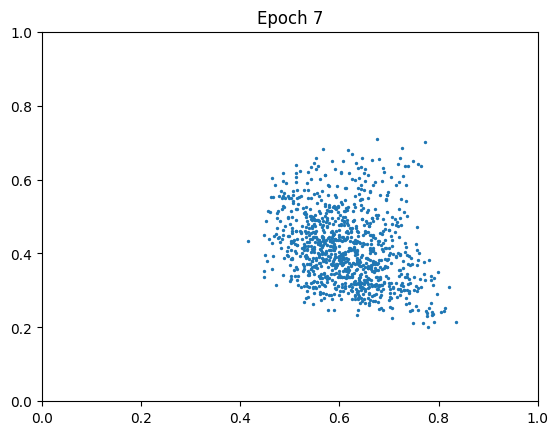

100%|██████████| 62/62 [00:58<00:00,  1.06it/s, G_loss=-.678, D_loss=0.676]

epoch: 8, D_loss: 0.6757649135205054, G_loss: -0.6777337183875423
a_loss: -42.01949054002762, b_loss: 35.52622465414318
좌표값 평균 =  0.5974551 0.457945


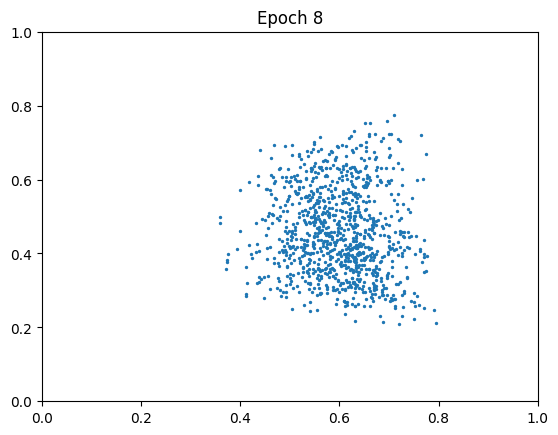

100%|██████████| 62/62 [00:59<00:00,  1.03it/s, G_loss=-.68, D_loss=0.676] 

epoch: 9, D_loss: 0.6761787822169643, G_loss: -0.6797425794985986
a_loss: -42.14403992891312, b_loss: 35.50146199839493
좌표값 평균 =  0.5884191 0.46262643


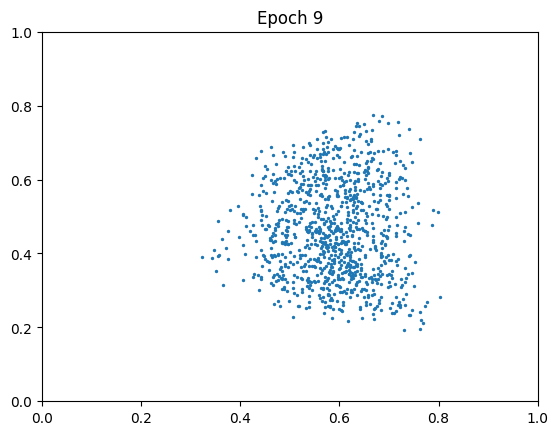

100%|██████████| 62/62 [00:59<00:00,  1.03it/s, G_loss=-.679, D_loss=0.679]

epoch: 10, D_loss: 0.6794589286850344, G_loss: -0.6793213467444142
a_loss: -42.11792349815369, b_loss: 36.41166351248866
좌표값 평균 =  0.5987877 0.4345782


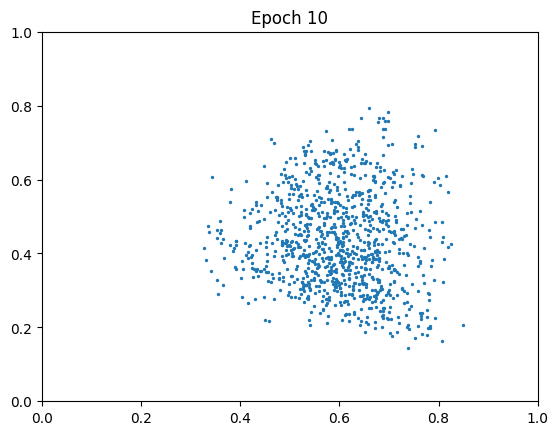

 37%|███▋      | 23/62 [00:22<00:41,  1.05s/it, G_loss=-.685, D_loss=0.687]

In [78]:
import os
epoch = 200
title = 'try6'
if not os.path.exists(f'result/{title}'):
    os.makedirs(f'result/{title}')

for rep in range(1, epoch+1):
    np.random.shuffle(x)
    iter_num = int(len(x) * 0.5 //BATCH_SIZE) # 매번 50% 추출해서 학습. 셔플하니까 자투리 생기는건 무시.
    G_loss_sum = 0.0
    D_loss_sum = 0.0
    pbar = tqdm(range(iter_num))
    generator_output = []

    a_loss_sum = 0
    b_loss_sum = 0
    recorder_keywords = ['d_loss', 'g_loss', 'a_loss', 'b_loss']
    recorder = {k: [] for k in recorder_keywords}
    
    for i in pbar:
        batch = torch.FloatTensor(x[BATCH_SIZE * i : BATCH_SIZE * i + BATCH_SIZE])
        
        # train discriminator
        generator_seed = torch.rand((BATCH_SIZE, n_qubits)) * 2 - 1
        fake_input, _ = generator_forward(generator_params, generator_seed) # 저기 _도 나중에 mi 넣을때 필요
        fake_input = fake_input.to(torch.float32)
        disc_loss = disc_cost_fn(batch, fake_input)

        D_opt.zero_grad()
        disc_loss.requires_grad_(True)
        disc_loss.backward()
        D_opt.step()

        # train generator
        generator_loss, a, b = generator_cost_fn(generator_params, mine=False, qmine=False)
        a_loss_sum += a.detach().numpy()
        b_loss_sum += b.detach().numpy()
        G_opt.zero_grad()
        generator_loss.requires_grad_(True)
        generator_loss.backward()
        G_opt.step()

        D_loss_sum += disc_loss.item()
        G_loss_sum += generator_loss.item()

        pbar.set_postfix({'G_loss': G_loss_sum/(i+1), 'D_loss': D_loss_sum/(i+1)})
        generator_output.append(fake_input.detach().numpy())

        recorder['d_loss'].append(disc_loss.item())
        recorder['g_loss'].append(generator_loss.item())
        recorder['a_loss'].append(a.detach().numpy())
        recorder['b_loss'].append(b.detach().numpy())
    
    generator_output = np.concatenate(generator_output, axis=0)
    print("epoch: {}, D_loss: {}, G_loss: {}".format(rep, D_loss_sum/iter_num, G_loss_sum/iter_num))
    print("a_loss: {}, b_loss: {}".format(a_loss_sum, b_loss_sum))
    print("좌표값 평균 = ", np.mean(generator_output[:,0]), np.mean(generator_output[:,1]))
    plt.title('Epoch {0}'.format(rep))
    plt.scatter(generator_output[:,0], generator_output[:,1], s=2.0)
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.savefig(f'result/{title}/{rep}.png')
    plt.show()

## 모델 저장 스크립트

In [87]:
import pickle
with open(f'result/{title}/discriminator.pkl', 'wb') as file:
    pickle.dump(discriminator, file)

with open(f'result/{title}/params.pkl', 'wb') as file:
    pickle.dump(generator_params, file)

## 결과 plot하는 코드

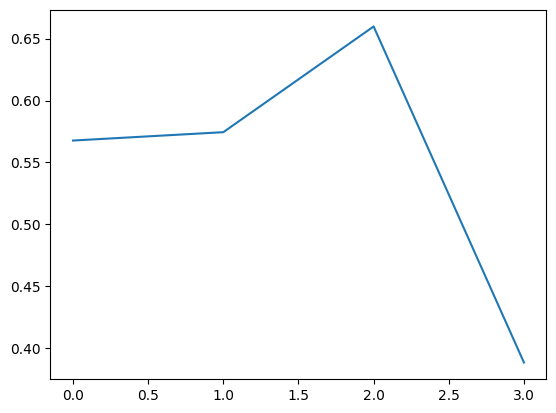

In [91]:
import matplotlib.pyplot as plt
plt.plot(recorder['d_loss'])

## 모델 불러오는 스크립트

In [ ]:
with open(f'result/{title}/discriminator.pkl', 'wb') as file:
    discriminator = pickle.load(file)

with open(f'result/{title}/params.pkl', 'wb') as file:
    generator_params = pickle.load(file)

In [38]:
title='try2'

In [104]:
import numpy as np
from scipy.stats import entropy

n = 100
array_1 = np.random.rand(n, 2)
array_2 = np.random.rand(n, 2)

# Compute relative entropy
entropy_values = entropy(array_1, array_2)
print("Relative Entropy values:", entropy_values.sum())

Relative Entropy values: 1.03111795131095


In [111]:
np.random.shuffle(array_2)
entropy_values = entropy(array_1, array_2)
print("Relative Entropy values:", entropy_values.sum())

Relative Entropy values: 1.101271117624759


In [116]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Example data: coordinates of points
n = 100
points_distribution_1 = np.random.rand(n, 2)
points_distribution_2 = np.random.rand(n, 2)

# Compute cosine similarity
cosine_sim_matrix = cosine_similarity(points_distribution_1, points_distribution_2)
average_cosine_similarity = np.mean(cosine_sim_matrix)

# Convert cosine similarity to a dissimilarity value (1 - similarity)
dissimilarity = 1 - average_cosine_similarity

print("Dissimilarity value:", dissimilarity)

Dissimilarity value: 0.14025951236743583


In [136]:
# Example data: coordinates of points
n = 100
points_distribution_1 = np.random.rand(n, 2)
points_distribution_2 = points_distribution_1

# Compute cosine similarity
cosine_sim_matrix = cosine_similarity(points_distribution_1, points_distribution_2)
average_cosine_similarity = np.mean(cosine_sim_matrix)

# Convert cosine similarity to a dissimilarity value (1 - similarity)
dissimilarity = 1 - average_cosine_similarity

print("Dissimilarity value:", dissimilarity)

Dissimilarity value: 0.16115308661716676


In [163]:
import numpy as np
from scipy.stats import entropy

def compute_mutual_information(p, q):
    assert len(p) == len(q), "Number of points must be the same"
    n = len(p)
    
    # Normalize distributions
    p_normalized = p / np.sum(p)
    q_normalized = q / np.sum(q)
    
    # Compute joint distribution
    joint_distribution = np.outer(p_normalized, q_normalized)
    
    # Compute marginal distributions
    p_marginal = np.sum(joint_distribution, axis=1)
    q_marginal = np.sum(joint_distribution, axis=0)
    
    # Compute mutual information
    mutual_info = np.sum(joint_distribution * np.log(joint_distribution / (p_marginal[:, None] * q_marginal)), where=(joint_distribution != 0))
    
    return mutual_info

# Example data: coordinates of points
n = 100
points_distribution_1 = np.random.rand(n, 2)
points_distribution_2 = np.random.rand(n, 2)

# Compute mutual information
mutual_info = compute_mutual_information(points_distribution_1, points_distribution_2)

print("Mutual Information:", mutual_info)

Mutual Information: -1.687499395323166e-16
